In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
import sklearn.model_selection as skm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from ISLP import load_data, confusion_table
from ISLP.models import (summarize,
                         poly,
                         ModelSpec as MS)

In [2]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

In [3]:
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)
from ISLP.bart import BART

In [4]:
##loading boston data
Boston = load_data("Boston")
Boston.columns

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'lstat', 'medv'],
      dtype='object')

In [5]:
y = Boston['nox']
dis = Boston['dis']

a)  a) use the poly() function from the ISLP.models module to fit a cubic polynomial regression to predict nox using dis. report the regression output, and plot the resulting data and polynomial fits.

In [6]:
poly_dis = MS([poly('dis', degree=3)]).fit(Boston)
M = sm.OLS(y, poly_dis.transform(Boston)).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,0.5547,0.003,201.021,0.0
"poly(dis, degree=3)[0]",-2.0031,0.062,-32.271,0.0
"poly(dis, degree=3)[1]",0.8563,0.062,13.796,0.0
"poly(dis, degree=3)[2]",-0.3180,0.062,-5.124,0.0


In [7]:
dis_grid = np.linspace(dis.min(),
                       dis.max(),
                       100)
dis_df = pd.DataFrame({'dis': dis_grid})

In [8]:
def plot_nox_fit(dis_df, 
                  basis,
                  title):

    X = basis.transform(Boston)
    Xnew = basis.transform(dis_df)
    M = sm.OLS(y, X).fit()
    preds = M.get_prediction(Xnew)
    bands = preds.conf_int(alpha=0.05)
    fig, ax = subplots(figsize=(8,8))
    ax.scatter(dis,
               y,
               facecolor='gray',
               alpha=0.5)
    for val, ls in zip([preds.predicted_mean,
                      bands[:,0],
                      bands[:,1]],
                     ['b','r--','r--']):
        ax.plot(dis_df.values, val, ls, linewidth=3)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('dis(Weighted mean of distances)', fontsize=20)
    ax.set_ylabel('nox(Nitrogen oxides concentration)', fontsize=20)
    return ax

<Axes: title={'center': 'Cubic Polynomial fit'}, xlabel='dis(Weighted mean of distances)', ylabel='nox(Nitrogen oxides concentration)'>

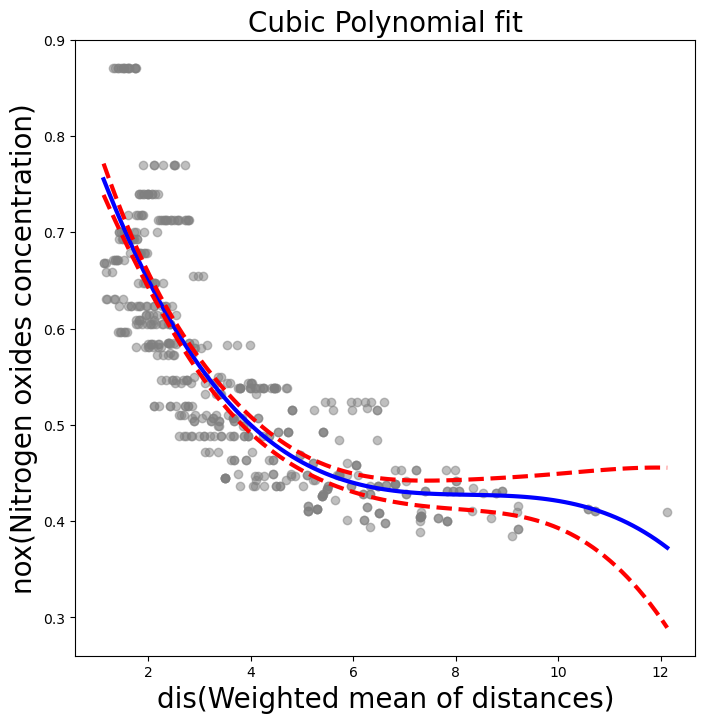

In [9]:
plot_nox_fit(dis_df, 
              poly_dis,
              'Cubic Polynomial fit')

b) plot the polynomial fits for a range of different polynomial degrees (say from 1 to 10), and report the associated residual sum of squares.

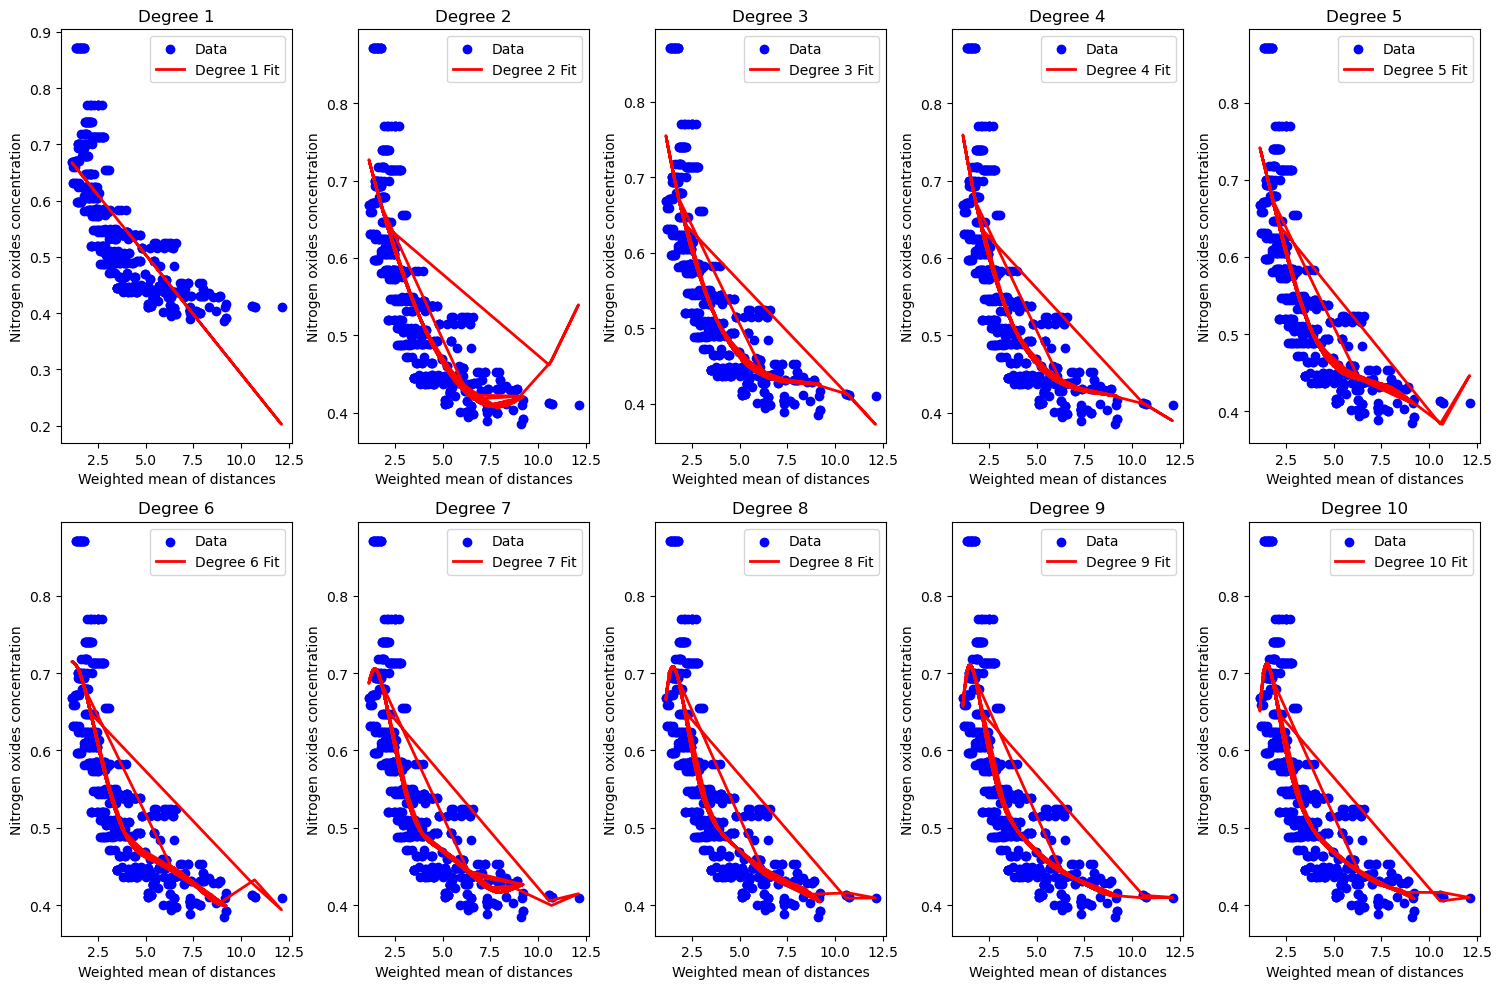

In [10]:
dis = Boston['dis'].values.reshape(-1, 1)
nox = Boston['nox'].values

degrees = np.arange(1, 11)
rss_values = []
plt.figure(figsize=(15,10))
for i in degrees:
    model = make_pipeline(PolynomialFeatures(i), LinearRegression())
    model.fit(dis, nox)
    nox_pred = model.predict(dis)
    residuals = nox - nox_pred
    rss = np.sum(residuals**2)
    rss_values.append(rss)
    
    plt.subplot(2, 5, i)
    plt.scatter(dis, nox, color='blue', label='Data')
    plt.plot(dis, model.predict(dis), color='red', linewidth=2, label=f'Degree {i} Fit')
    plt.title(f'Degree {i}')
    plt.xlabel('Weighted mean of distances')
    plt.ylabel('Nitrogen oxides concentration')
    plt.legend()
plt.tight_layout()
plt.show()
    

In [11]:
for i, rss in zip(degrees, rss_values):
    print(f'Degree {i}: Associated residual sum of squares. = {rss:.2f}')

Degree 1: Associated residual sum of squares. = 2.77
Degree 2: Associated residual sum of squares. = 2.04
Degree 3: Associated residual sum of squares. = 1.93
Degree 4: Associated residual sum of squares. = 1.93
Degree 5: Associated residual sum of squares. = 1.92
Degree 6: Associated residual sum of squares. = 1.88
Degree 7: Associated residual sum of squares. = 1.85
Degree 8: Associated residual sum of squares. = 1.84
Degree 9: Associated residual sum of squares. = 1.83
Degree 10: Associated residual sum of squares. = 1.83


C) Perform cross-validation or another approach to select the optimal degree for the polynomial and explain your results.

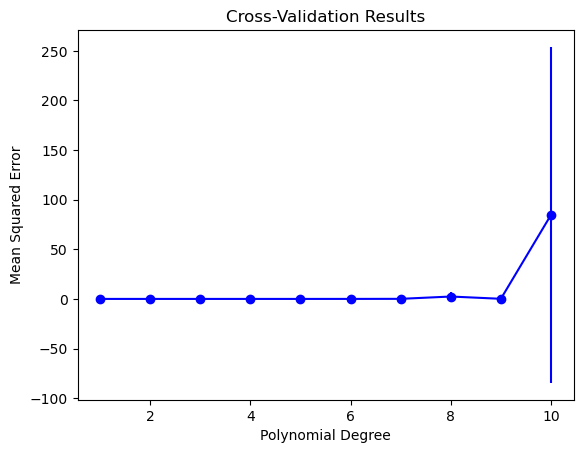

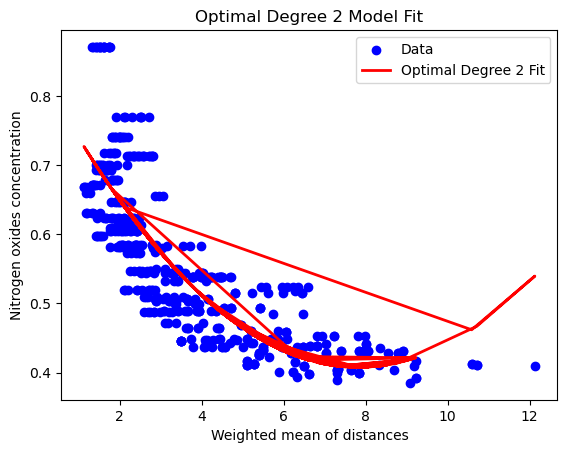

Optimal Degree: 2


In [12]:
from sklearn.model_selection import cross_val_score

degrees = np.arange(1, 11)
cv_scores_mean = []
cv_scores_std = []

for i in degrees:
    model = make_pipeline(PolynomialFeatures(i), LinearRegression())
    # cross-validation
    cv_scores = cross_val_score(model, dis, nox, cv=5, scoring='neg_mean_squared_error')
    cv_scores_mean.append(-np.mean(cv_scores))
    cv_scores_std.append(np.std(cv_scores))

# Find the degree with the minimum cross-validated error
optimal_degree = np.argmin(cv_scores_mean) + 1

# ross-validation results
plt.errorbar(degrees, cv_scores_mean, yerr=cv_scores_std, marker='o', linestyle='-', color='b')
plt.title('Cross-Validation Results')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error')
plt.show()

# optimal degree
optimal_model = make_pipeline(PolynomialFeatures(optimal_degree), LinearRegression())
optimal_model.fit(dis, nox)

# optimal model fit
plt.scatter(dis, nox, color='blue', label='Data')
plt.plot(dis, optimal_model.predict(dis), color='red', linewidth=2, label=f'Optimal Degree {optimal_degree} Fit')
plt.title(f'Optimal Degree {optimal_degree} Model Fit')
plt.xlabel('Weighted mean of distances')
plt.ylabel('Nitrogen oxides concentration')
plt.legend()
plt.show()

print(f'Optimal Degree: {optimal_degree}')

explaination: The optimal degree is determined as the one with the minimum mean squared error.

If the optimal degree is low (e.g., 1 or 2), it suggests that a simple linear or quadratic model is sufficient to explain the relationship between the features and the target variable.
If the optimal degree is high, it might indicate that a more complex model is needed to capture the underlying patterns, but be cautious about potential overfitting to the training data.

Chapter 8 
3. Consider the Gini index, classification error, and entropy in a simple
classification setting with two classes. Create a single plot that displays
each of these quantities as a function of ˆpm1. The x-axis should
display ˆpm1, ranging from 0 to 1, and the y-axis should display the
value of the Gini index, classification error, and entropy.
Hint: In a setting with two classes, ˆpm1 = 1 − ˆpm2. You could make
this plot by hand, but it will be much easier to make in R.

C:\Users\deepa\AppData\Local\Temp\ipykernel_16260\3666714764.py:9: RuntimeWarning: divide by zero encountered in log2
  entropy = -pm1 * np.log2(pm1) - pm2 * np.log2(pm2)
C:\Users\deepa\AppData\Local\Temp\ipykernel_16260\3666714764.py:9: RuntimeWarning: invalid value encountered in multiply
  entropy = -pm1 * np.log2(pm1) - pm2 * np.log2(pm2)


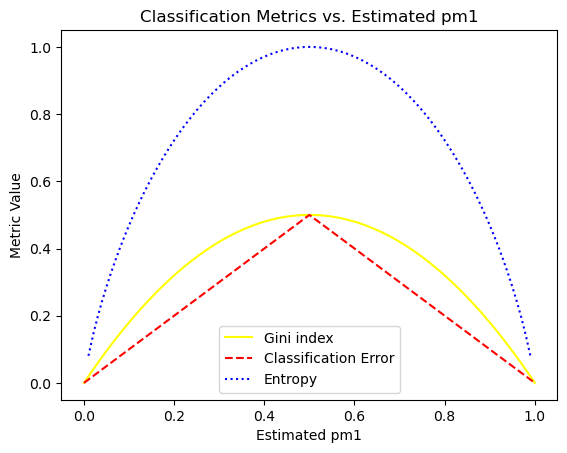

In [13]:
pm1 = np.arange(0, 1.01, 0.01)
pm2 = 1 - pm1

# Calculate Gini index
gini = 2 * pm1 * pm2

classification_error = 1 - np.maximum(pm1, pm2)

entropy = -pm1 * np.log2(pm1) - pm2 * np.log2(pm2)


plt.plot(pm1, gini, label='Gini index', color='yellow')
plt.plot(pm1, classification_error, label='Classification Error', color='red', linestyle='--')
plt.plot(pm1, entropy, label='Entropy', color='blue', linestyle='dotted')


plt.xlabel('Estimated pm1')
plt.ylabel('Metric Value')
plt.title('Classification Metrics vs. Estimated pm1')
plt.legend()


plt.show()

5. Suppose we produce ten bootstrapped samples from a data set
containing red and green classes. We then apply a classification tree
to each bootstrapped sample and, for a specific value of X, produce
10 estimates of P(Class is Red|X):
0.1, 0.15, 0.2, 0.2, 0.55, 0.6, 0.6, 0.65, 0.7, and 0.75.
There are two common ways to combine these results together into a
single class prediction. One is the majority vote approach discussed in
this chapter. The second approach is to classify based on the average
probability. In this example, what is the final classification under each
of these two approaches?

In [14]:
probabilities = np.array([0.1, 0.15, 0.2, 0.2, 0.55, 0.6, 0.6, 0.65, 0.7, 0.75])

# Majority Vote Approach
majority_vote = 1 if np.sum(probabilities >= 0.5) > len(probabilities) / 2 else 0
print(f"Majority Vote Prediction: {'Red' if majority_vote == 1 else 'Green'}")

# Average Probability Approach
aver_probability = np.mean(probabilities)
aver_prob_pred = 1 if aver_probability >= 0.5 else 0
print(f"Average Probability Prediction: {'Red' if aver_prob_pred == 1 else 'Green'}")

Majority Vote Prediction: Red
Average Probability Prediction: Green


8) In the lab, a classification tree was applied to the Carseats data set after
converting Sales into a qualitative response variable. Now we will
seek to predict Sales using regression trees and related approaches,
treating the response as a quantitative variable.

a) Split the data set into a training set and a test set.

In [15]:
data = load_data("Carseats")
data.columns

Index(['Sales', 'CompPrice', 'Income', 'Advertising', 'Population', 'Price',
       'ShelveLoc', 'Age', 'Education', 'Urban', 'US'],
      dtype='object')

In [16]:
data

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...
395,12.57,138,108,17,203,128,Good,33,14,Yes,Yes
396,6.14,139,23,3,37,120,Medium,55,11,No,Yes
397,7.41,162,26,12,368,159,Medium,40,18,Yes,Yes
398,5.94,100,79,7,284,95,Bad,50,12,Yes,Yes


In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split

# change categorical columns data into numericals
data['US'] = data['US'].map({'Yes': 1, 'No': 0})
data['Urban'] = data['Urban'].map({'Yes': 1, 'No': 0})
data = pd.get_dummies(data, columns=['ShelveLoc'], prefix=['ShelveLoc'])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data.drop(['Sales'], axis=1),
                                                    data[['Sales']], test_size=0.2)


print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (320, 12) (320, 1)
Test set shape: (80, 12) (80, 1)


b) Fit a regression tree to the training set. Plot the tree, and interpret
the results. What test MSE do you obtain?

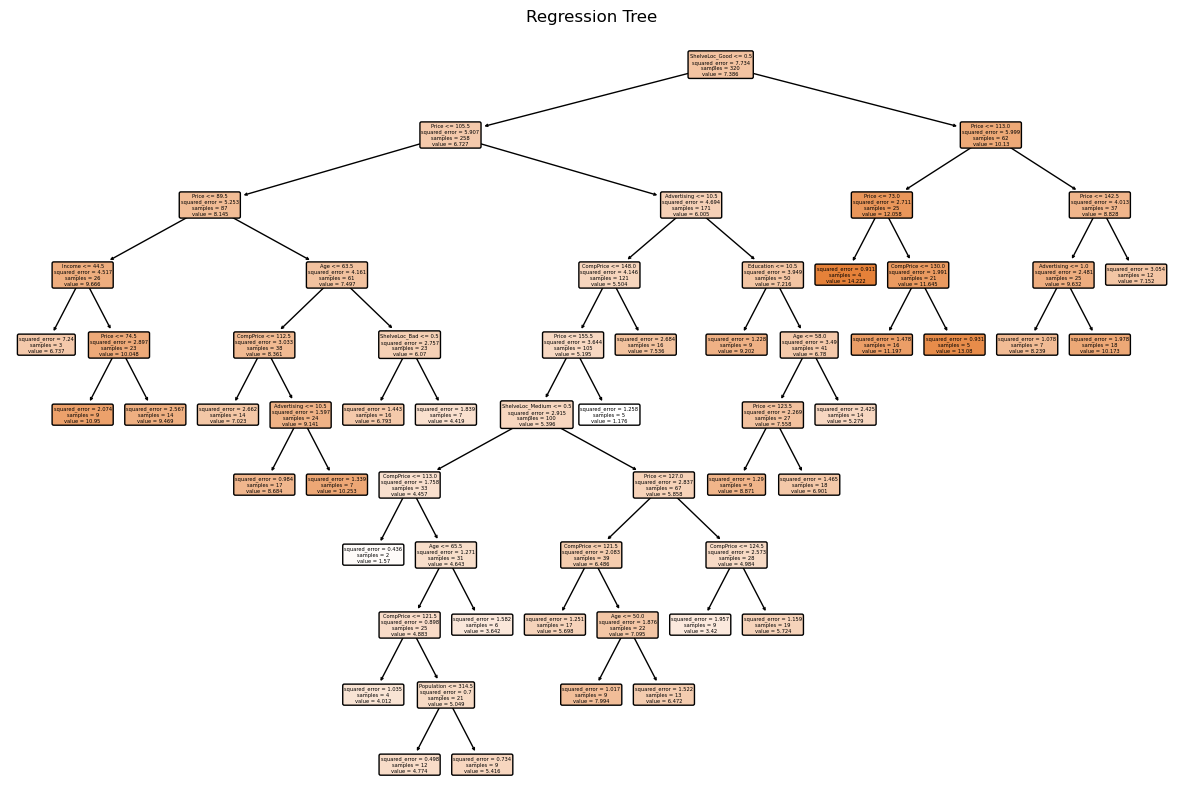

Test Mean Squared Error: 4.415804008957688


In [18]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import plot_tree



reg_tree = DecisionTreeRegressor(random_state=42, min_samples_split=20)
reg_tree.fit(X_train, y_train)

plt.figure(figsize=(15, 10))
plot_tree(reg_tree, filled=True, feature_names=X_train.columns.tolist(), rounded=True)
plt.title("Regression Tree")
plt.show()

y_train_pred = reg_tree.predict(X_train)
y_test_pred = reg_tree.predict(X_test)

train_error = mean_squared_error(y_train, y_train_pred)
test_error = mean_squared_error(y_test, y_test_pred)

print(f"Test Mean Squared Error: {test_error}")

(c) Use cross-validation in order to determine the optimal level of
tree complexity. Does pruning the tree improve the test MSE?

In [20]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': range(1, 11), 
    'min_samples_split': range(2, 11),  
    'min_samples_leaf': range(1, 11)
}


reg_tree12 = DecisionTreeRegressor(random_state=42)


grid_search = GridSearchCV(reg_tree12, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Hyper-parameters:", best_params)


best_reg_tree = DecisionTreeRegressor(**best_params, random_state=42)
best_reg_tree.fit(X_train, y_train)


y_pred_pruned = best_reg_tree.predict(X_test)

# Mean Squared Error (MSE) on the pruned tree
test_mse_pruned = mean_squared_error(y_test, y_pred_pruned)
print("Test MSE on the Pruned Tree:", test_mse_pruned)

Best Hyper-parameters: {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 7}
Test MSE on the Pruned Tree: 4.491484510784434


(d) Use the bagging approach in order to analyze this data. What
test MSE do you obtain? Use the feature_importance_ values to
determine which variables are most important.

In [19]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

carseats = load_data("Carseats")
carseats.columns

# categorical to binary
carseats['US'] = carseats['US'].map({'Yes': 1, 'No': 0})
carseats['Urban'] = carseats['Urban'].map({'Yes': 1, 'No': 0})

# One-hot encode categorical variables including 'ShelveLoc'
data_encoded = pd.get_dummies(carseats, columns=['ShelveLoc'])


X = data_encoded.drop('Sales', axis=1) 
y = data_encoded['Sales']

# Split the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Create a decision tree regressor (base model)
base_model = DecisionTreeRegressor(random_state=42)

# Create a bagging regressor
bagging_model = BaggingRegressor(base_model, n_estimators=100, random_state=42)

# Fit the bagging model to the training set
bagging_model.fit(X_train, y_train)

# Predictions on the test set
y_pred_bagging = bagging_model.predict(X_test)

# Calculate Mean Squared Error (MSE) for the bagging model
test_mse_bagging = mean_squared_error(y_test, y_pred_bagging)
print("Test MSE (Bagging):", test_mse_bagging)

# Get feature importances
feature_importances = bagging_model.estimators_[0].feature_importances_

# Print feature importances for each variable
for feature, importance in zip(X.columns, feature_importances):
    print(f"{feature}: {importance}")


Test MSE (Bagging): 3.0433496307499985
CompPrice: 0.08186900662628076
Income: 0.03832581195378998
Advertising: 0.06741876574348239
Population: 0.031593570477272154
Price: 0.33132155089375664
Age: 0.1193068144387101
Education: 0.009974446057887092
Urban: 0.00808730575658773
US: 0.004056671606103409
ShelveLoc_Bad: 0.0
ShelveLoc_Good: 0.2246208699377159
ShelveLoc_Medium: 0.08342518650841396


(e) Use random forests to analyze this data. What test MSE do
you obtain? Use the feature_importance_ values to determine
which variables are most important. Describe the effect of m, the
number of variables considered at each split, on the error rate
obtained.

In [20]:
from sklearn.ensemble import RandomForestRegressor
# Fit a Random Forest to the training set
random_forest = RandomForestRegressor(n_estimators=100, max_features='sqrt', random_state=42)
random_forest.fit(X_train, y_train)

# Prediction
y_pred_rf = random_forest.predict(X_test)

# MSE
test_mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Test MSE with Random Forest: {test_mse_rf}")

# feature importance
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': random_forest.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)


max_features_values = [None, 'sqrt', 'log2', 0.3, 0.9] 
for max_features_value in max_features_values:
    rf = RandomForestRegressor(n_estimators=100, max_features=max_features_value, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"\nTest MSE with max_features={max_features_value}: {mse}")


Test MSE with Random Forest: 3.660196758875

Feature Importance:
             Feature  Importance
4              Price    0.226685
5                Age    0.123641
10    ShelveLoc_Good    0.112900
2        Advertising    0.090081
0          CompPrice    0.089206
9      ShelveLoc_Bad    0.084321
1             Income    0.083976
3         Population    0.071250
6          Education    0.049871
11  ShelveLoc_Medium    0.041444
8                 US    0.015734
7              Urban    0.010891

Test MSE with max_features=None: 3.065207220625

Test MSE with max_features=sqrt: 3.660196758875

Test MSE with max_features=log2: 3.660196758875

Test MSE with max_features=0.3: 3.660196758875

Test MSE with max_features=0.9: 3.0870935013749987


f) Now analyze the data using BART, and report your results.

In [23]:

carseats = load_data("Carseats")
carseats.columns

# categorical to binary
carseats['US'] = carseats['US'].map({'Yes': 1, 'No': 0})
carseats['Urban'] = carseats['Urban'].map({'Yes': 1, 'No': 0})

# One-hot encode categorical variables including 'ShelveLoc'
data_encoded = pd.get_dummies(carseats, columns=['ShelveLoc'])


X = data_encoded.drop('Sales', axis=1) 
y = data_encoded['Sales']

# Split the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

# Create BART model
bart_model = BART()
bart_model.fit(X_train_np, y_train_np)

# Prediction
y_pred = bart_model.predict(X_test_np)

# Mean Squared Error on the test set
test_mse = mean_squared_error(y_test_np, y_pred)
print(f"Test MSE using BART: {test_mse:.4f}")

Test MSE using BART: 1.3641
